In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

### Read in data

In [2]:
data = pd.read_csv('./dataset/shortened_dataset.csv')

In [3]:
data.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#### Quick EDA

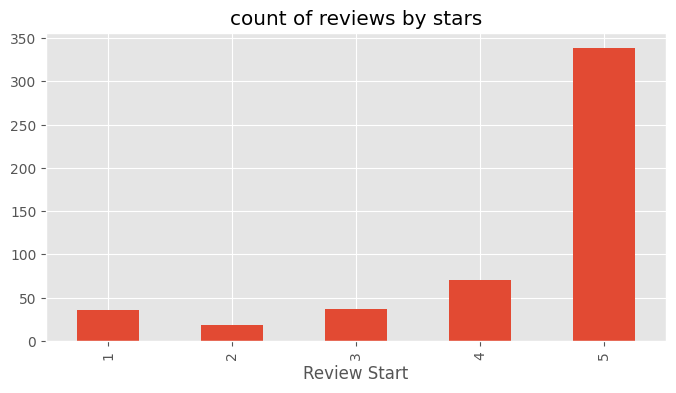

In [4]:
ax = data['Score'].value_counts().sort_index()\
            .plot(kind='bar', 
            title='count of reviews by stars',
            figsize=(8, 4))
ax.set_xlabel('Review Start')
plt.show()

# \ is necessary for a break that allows .plot() to still function. No space before or after \ is allowed 

#### Basic NLTK

In [5]:
# nltk.download('punkt') # necessary to download tokenizers

# nltk.download('averaged_perceptron_tagger') # necessary for part of speech tags

# nltk.download('maxent_ne_chunker') # chunkers
# nltk.download('words') # also for chunkers

# nltk.download('vader_lexicon') #vader SIA

In [6]:
# !pip install ipywidgets
# from ipywidgets import FloatProgress

In [7]:
example = data['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged = nltk.pos_tag(tokens)

The following [link](https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/#) has more information about what each part of speech tag relates to

In [10]:
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
entities = nltk.chunk.ne_chunk(tagged) # chunks/groups entities into related words based on tags
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Sentiment Analysis with VADER
---
We will use NLTK's <SentimentIntensityAnalyzer> to get the neg/neu/pos scores for the text
- This uses a "big bag of words" approach, meaning stop words are removed and each word is scored and combined for a total score
- This doesn't account for relationships between words 

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
# from tdqm.notebook import tdqm # progress bar

sia = SentimentIntensityAnalyzer()

In [13]:
sia.polarity_scores('I am so happy!')
# compound score is from -1 to 1, representing the sentiment of the whole text

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [14]:
sia.polarity_scores('This is the worst thing ever!')
# a value < 0 is negative, while a value > 0 is positive sentiment

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [15]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [16]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['Text']
    myID = row['Id']
    res[myID] = sia.polarity_scores(text)
    

100%|██████████| 500/500 [00:00<00:00, 902.54it/s]


In [17]:
vaders = pd.DataFrame(res).T # .T transposes the df
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(data, how='left')

In [18]:
# now we have sentiment score and meta data
vaders.head()

,Id,neg,neu,pos,compound,Unnamed: 0,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER results

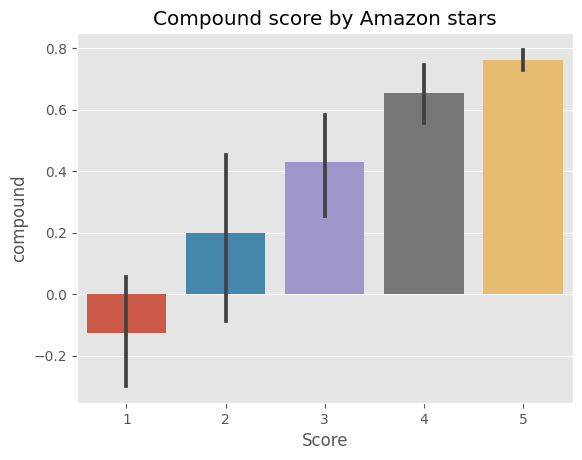

In [22]:
fig = plt.figure()
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound score by Amazon stars')
plt.show()

In [24]:
fig.savefig('Vader - compound vs score')

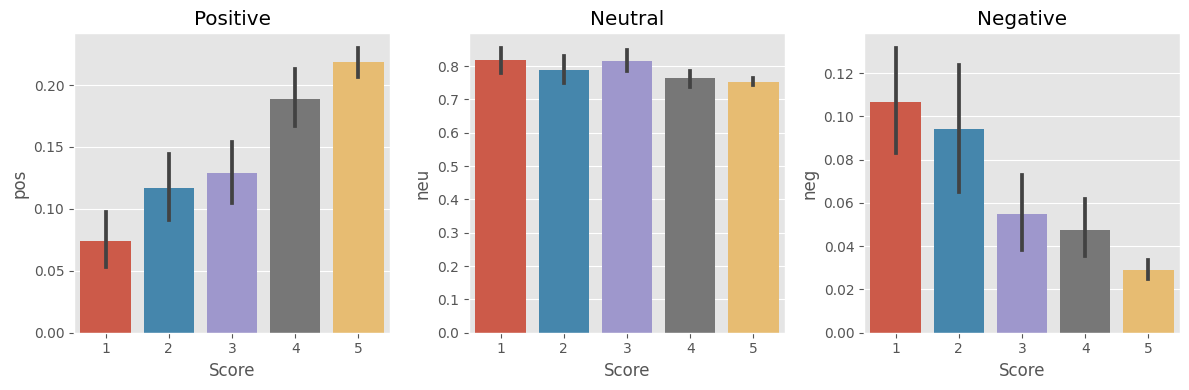

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [27]:
fig.savefig('Vader - each vs score')

## Roberta Pretrained Model
---

Here, we will use a model trained on a large amount of data. This transformer model accounts for words but also accounts for context related to the other words in the review.

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" #provided by HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

The above model is an example of "Transfer Learning". The model was trained on lots of labeled tweets to determine sentiment. We're applying that trained model with its given weights to our dataset.

In [30]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [31]:
sia.polarity_scores(example) # VADER results on example

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [32]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt') #pt = PyTorch

In [33]:
Roberta_output = model(**encoded_text)

In [34]:
Roberta_output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [35]:
# Take output from Tensor to numpy for local storage
scores = Roberta_output[0][0].detach().numpy()
scores

array([ 3.1436296, -0.7106688, -2.6558964], dtype=float32)

In [36]:
scores = softmax(scores)
scores # neg, neu, pos

array([0.97635514, 0.02068747, 0.00295737], dtype=float32)

In [37]:
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687466,
 'roberta_pos': 0.0029573694}

### Run on data set

In [38]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
    }
    return scores_dict

In [39]:
scores_dict = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        # rename vader results to be clearer
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        
        roberta_result = polarity_scores_roberta(text)
        both = vader_result_rename | roberta_result # join dictionaries
        scores_dict[myid] = both
    except RuntimeError:
        print(f'Skipped ID: {myid}')


 17%|█▋        | 83/500 [00:32<03:04,  2.26it/s]

Skipped ID: 83


 38%|███▊      | 188/500 [01:12<01:07,  4.62it/s]

Skipped ID: 187


100%|██████████| 500/500 [03:12<00:00,  2.59it/s]


Note that this is quite slow. This is because it is only running on a CPU, whereas Roberta (being a DL neural net) is optimized to run on a GPU

In [40]:
scores_dict

{1: {'vader_neg': 0.0,
  'vader_neu': 0.695,
  'vader_pos': 0.305,
  'vader_compound': 0.9441,
  'roberta_neg': 0.009624239,
  'roberta_neu': 0.04998042,
  'roberta_pos': 0.94039536},
 2: {'vader_neg': 0.138,
  'vader_neu': 0.862,
  'vader_pos': 0.0,
  'vader_compound': -0.5664,
  'roberta_neg': 0.50898594,
  'roberta_neu': 0.45241368,
  'roberta_pos': 0.038600374},
 3: {'vader_neg': 0.091,
  'vader_neu': 0.754,
  'vader_pos': 0.155,
  'vader_compound': 0.8265,
  'roberta_neg': 0.003228903,
  'roberta_neu': 0.09806742,
  'roberta_pos': 0.8987037},
 4: {'vader_neg': 0.0,
  'vader_neu': 1.0,
  'vader_pos': 0.0,
  'vader_compound': 0.0,
  'roberta_neg': 0.0022951283,
  'roberta_neu': 0.09021927,
  'roberta_pos': 0.9074856},
 5: {'vader_neg': 0.0,
  'vader_neu': 0.552,
  'vader_pos': 0.448,
  'vader_compound': 0.9468,
  'roberta_neg': 0.0016347268,
  'roberta_neu': 0.010302461,
  'roberta_pos': 0.98806286},
 6: {'vader_neg': 0.029,
  'vader_neu': 0.809,
  'vader_pos': 0.163,
  'vader_compo

In [41]:
results_df = pd.DataFrame(scores_dict).T # .T transposes the df
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(data, how='left')

In [42]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Unnamed: 0,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Compare scores between models

In [43]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

<Figure size 640x480 with 0 Axes>

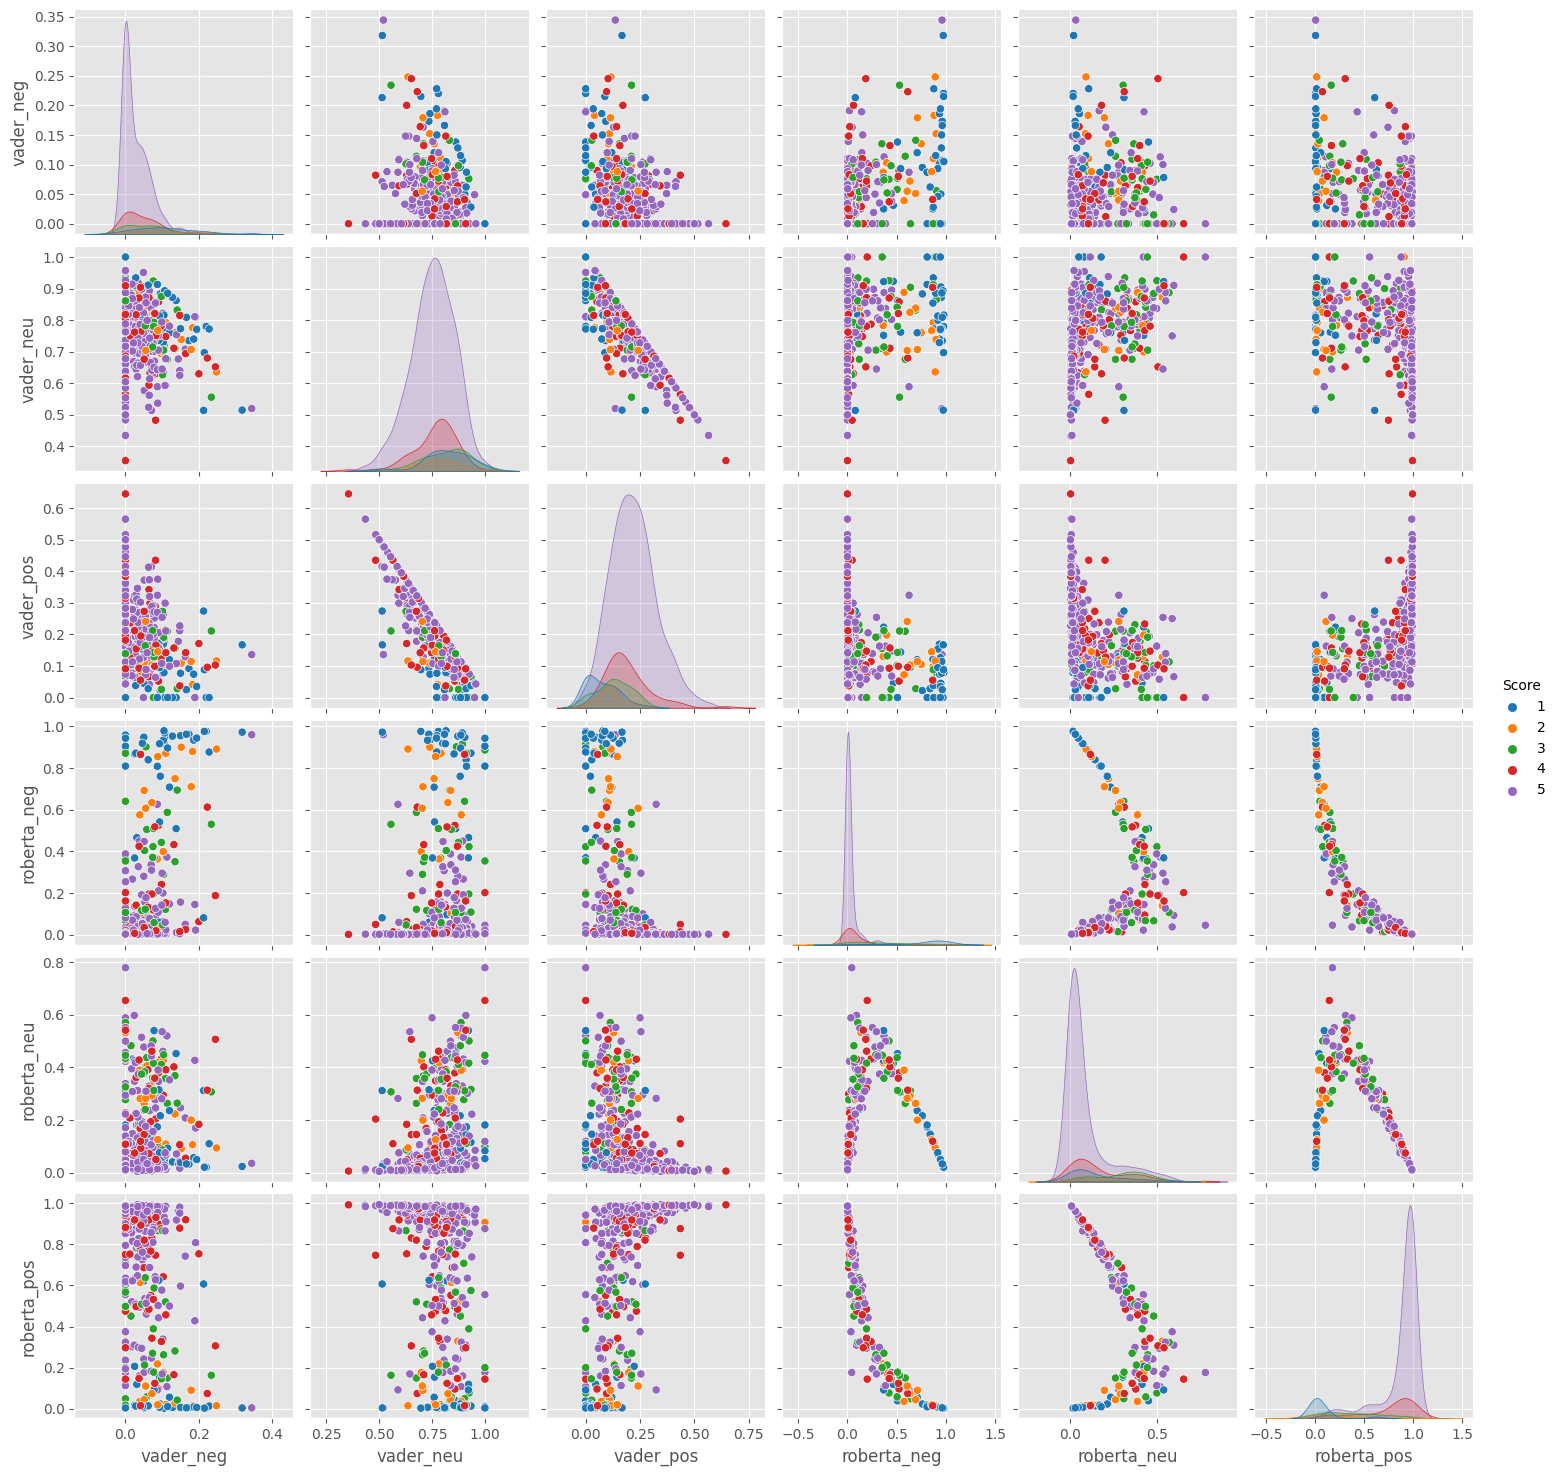

In [44]:
fig = plt.figure()
ax = sns.pairplot(data=results_df, 
             vars= ['vader_neg', 'vader_neu', 'vader_pos'
                    ,'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

In [45]:
ax.savefig('Roberta vs vader')

### Review some examples:
---
- Positive 1 star and negative 5 star reviews

Let's look at some examples where the model scoring and review score differ the most

In [46]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0] # 1 star, positive reviews

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

The above statement starts out positive, but is overall negative. This is a 1 star review that Roberta ranked as positive

In [47]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0] # 1 star, positive reviews

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

Similarly, VADER ranked this as positive, when it is a 1 star review

In [48]:
# negative sentiment 5 star review
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0] # 1 star, positive reviews

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [49]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0] # 1 star, positive reviews

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

Interestingly, both of the models selected this review to be of negative sentiment

### Extra: The Transformers Pipeline
---
- Quick and easy way to run sentiment predictions

In [50]:
from transformers import pipeline

In [51]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


This will automatically download their default model and embeddings for this pipeline, so you can run sentiment analysis with 2 lines of code. If you wish, you can also alter the model and tokenizer that the pipeline uses to perform this action.

In [52]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

Notice the output format changes, but otherwise, it's quick and easy to employ